# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

**Целевой признак**  
Price — цена (евро)

## Подготовка данных

### Анализ входных данных

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import time 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ShuffleSplit
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#переведем названия столбцов в нижний регистр
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
df.duplicated().sum()

4

In [8]:
df[df.duplicated(keep=False)]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


<AxesSubplot:>

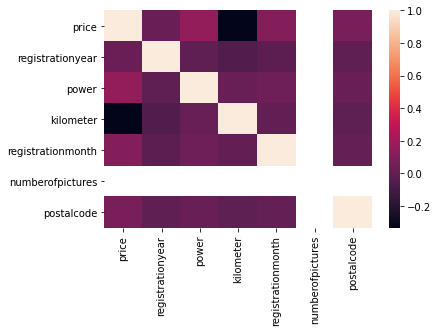

In [9]:
sns.heatmap(df.corr())

In [10]:
df.describe(include=['object', 'bool'])

,datecrawled,vehicletype,gearbox,model,fueltype,brand,notrepaired,datecreated,lastseen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [11]:
print('Дата создания первой анкеты:', df['datecreated'].min())
print('Дата создания последнией анкеты:', df['datecreated'].max())

Дата создания первой анкеты: 2014-03-10 00:00:00
Дата создания последнией анкеты: 2016-04-07 00:00:00


In [12]:
print('Период последней активности пользователей:')
print('с:', df['lastseen'].min())
print('по:', df['lastseen'].max())

Период последней активности пользователей:
с: 2016-03-05 14:15:08
по: 2016-04-07 14:58:51


**- данные загружены корректно**  
**- в 5 столбцах имеются пропуски (VehicleType, Gearbox, Model, FuelType, NotRepaired)**  
**- есть 4 полных дупликата**  
**- высокой корреляции в данных между столбцами не выявлено**  
**- в базе содержаться анкеты за 2 года, однако сроки последней активности пользователей укладываются в 1 месяц**  
**- имеются некоректные 0-ые значения в 3-х столбцах (Price, Power, RegistrationMonth)**  
**- имеются неккоректные данные в столбце registrationyear**  
**- все значения numberofpictures равны 0**

In [13]:
# уберем дупликаты из данных
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(354365, 16)

In [14]:
def nan_df (column):
    print('Количчество пропущеных значений в столбце', column, ':',
          round(df[column].isnull().sum()/len(df[column])*100, 2), '%')
    print ('Доля значений столбца', column, 'в %:')
    print(round(df[column].value_counts()/len(df[column])*100,2))

def nan_df_hist (column, title):    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    plt.ylabel('Частота')
    sns.countplot(x=column, data=df)

In [15]:
#функция по заполнения Nan аналогичными значениями из строк похожих по другим параметрам
def analog(column1, column2, column3):
    df[column1] = df.groupby([column2, column3])[column1].transform(lambda x: x.fillna((x.mode()[0]
                                                                                      if not x.mode().empty else 'other')))

In [16]:
#внесение и контроль изменений

def tab (column, time):
    summa = df[column].value_counts()
    percent = round(df[column].value_counts()/len(df[column])*100,2)
    percent=pd.DataFrame({column:percent.index, time+'_percent':percent.values})
    summa=pd.DataFrame({column:summa.index, time+'_sum':summa.values})
    result=summa.merge(percent)
    return result

def control(column1, column2, column3):
    before = tab (column1, 'befor') 
    analog(column1, column2, column3)
    after = tab (column1, 'after')  
    print(f' Изменения в графе {column1} (до и после):')
    return print(before.merge(after))

### Признак Model

In [17]:
nan_df('model')

Количчество пропущеных значений в столбце model : 5.56 %
Доля значений столбца model в %:
golf                  8.25
other                 6.89
3er                   5.58
polo                  3.69
corsa                 3.55
                      ... 
serie_2               0.00
rangerover            0.00
serie_3               0.00
range_rover_evoque    0.00
serie_1               0.00
Name: model, Length: 250, dtype: float64


**- мы не можем определить пропущенные модели исходя из предоставленных данных**  
**- если мы заменим пропуски в данном столбце на значение other, то мы получим выброс в 12,45% по данному значению, что не приемлемо**  
**- так как объем данных составляет более 350000 строк и количество пропусков по признаку "model" составляет 5.56% - пожертвуем этими данными и удалим эти строки**

In [18]:
df = df[df['model'].notna()]

### Признак Vehicletype

In [19]:
nan_df('vehicletype')

Количчество пропущеных значений в столбце vehicletype : 9.16 %
Доля значений столбца vehicletype в %:
sedan          26.33
small          22.86
wagon          18.82
bus             8.31
convertible     5.77
coupe           4.55
suv             3.36
other           0.84
Name: vehicletype, dtype: float64


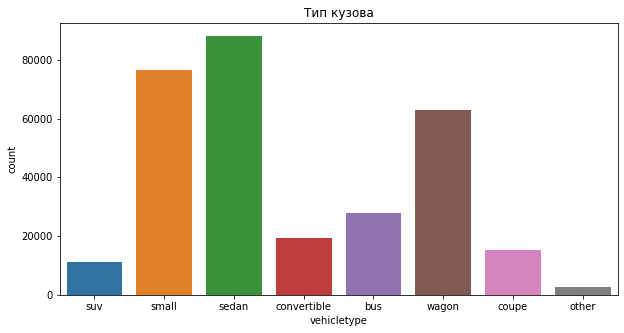

In [20]:
nan_df_hist('vehicletype', 'Тип кузова')

In [21]:
# заменим отсутствующие значения кузова значениями у аналогичной марки автомобиля
# если модель отстутствует - то меняем на other
control('vehicletype', 'brand', 'model')

 Изменения в графе vehicletype (до и после):
   vehicletype  befor_sum  befor_percent  after_sum  after_percent
0        sedan      88119          26.33     100773          30.11
1        small      76493          22.86      85608          25.58
2        wagon      62995          18.82      66536          19.88
3          bus      27794           8.31      31553           9.43
4  convertible      19319           5.77      19591           5.85
5        coupe      15237           4.55      15863           4.74
6          suv      11237           3.36      11907           3.56
7        other       2804           0.84       2829           0.85


### Признак Gearbox

In [22]:
nan_df('gearbox')

Количчество пропущеных значений в столбце gearbox : 4.69 %
Доля значений столбца gearbox в %:
manual    76.47
auto      18.84
Name: gearbox, dtype: float64


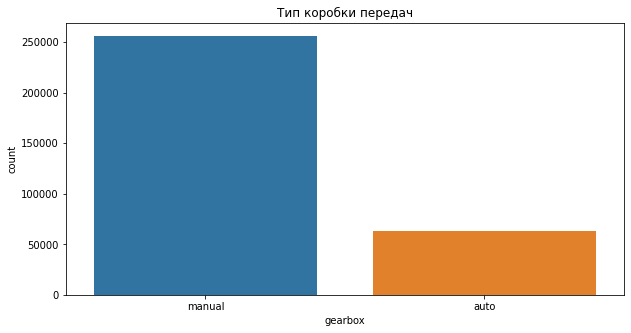

In [23]:
nan_df_hist('gearbox', 'Тип коробки передач')

In [24]:
# заменим отсутствующие значения трансмиссии значениями у аналогичной марки автомобиля
# если модель отстутствует - то меняем на other
control('gearbox', 'brand', 'model')

 Изменения в графе gearbox (до и после):
  gearbox  befor_sum  befor_percent  after_sum  after_percent
0  manual     255922          76.47     269674          80.58
1    auto      63036          18.84      64986          19.42


### Признак Fueltype

In [25]:
nan_df('fueltype')

Количчество пропущеных значений в столбце fueltype : 7.69 %
Доля значений столбца fueltype в %:
petrol      61.90
gasoline    28.64
lpg          1.48
cng          0.16
hybrid       0.06
other        0.04
electric     0.02
Name: fueltype, dtype: float64


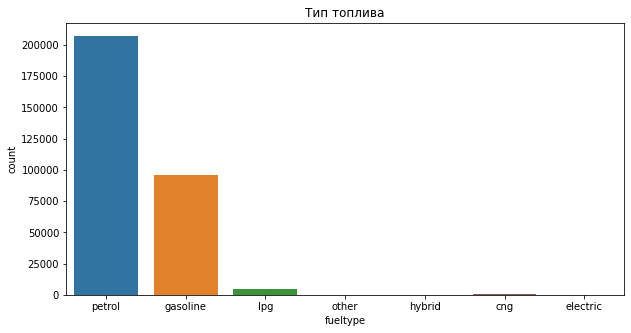

In [26]:
nan_df_hist('fueltype', 'Тип топлива')

In [27]:
control('fueltype', 'brand', 'model')

 Изменения в графе fueltype (до и после):
   fueltype  befor_sum  befor_percent  after_sum  after_percent
0    petrol     207159          61.90     227992          68.13
1  gasoline      95856          28.64     100755          30.11
2       lpg       4962           1.48       4962           1.48
3       cng        544           0.16        544           0.16
4    hybrid        208           0.06        208           0.06
5     other        133           0.04        133           0.04
6  electric         66           0.02         66           0.02


**- petrol и gasoline - это принятое в разных странах обозначение бензина**  
**- lpg и cng - это обозначения газа (бутани и метан соответсвенно)**  
**- после заполнеия пропусков доля бензиновых двигателей составила более 98%**  
**- в связи с таким большим перевесом в данных, уберем в дальнейшем данный признак из нашей модели**

In [28]:
df=df.drop(['fueltype'], axis=1)

### Признак Notrepaired

In [29]:
nan_df('notrepaired')

Количчество пропущеных значений в столбце notrepaired : 18.56 %
Доля значений столбца notrepaired в %:
no     71.37
yes    10.07
Name: notrepaired, dtype: float64


In [30]:
#так как пропусков в графе ремонт достаточно много (18,56%)
#и мы не можем с точностью сказать был ли ремонт или нет
#запоним пропуски данными по ремонту аналогичных моделей аналогичного года выпуска
#заменим неопределенные значения на no

analog('notrepaired', 'registrationyear', 'model')
df['notrepaired'] = df['notrepaired'].replace('other', 'no')
nan_df('notrepaired')

Количчество пропущеных значений в столбце notrepaired : 0.0 %
Доля значений столбца notrepaired в %:
no     89.83
yes    10.17
Name: notrepaired, dtype: float64


In [31]:
# у нас всего 2 признака - заменим no на 0, yes а 1
df['notrepaired'] = df['notrepaired'].replace('no', 0)
df['notrepaired'] = df['notrepaired'].replace('yes', 1)

### Признак Price

Text(0, 0.5, 'Частота')

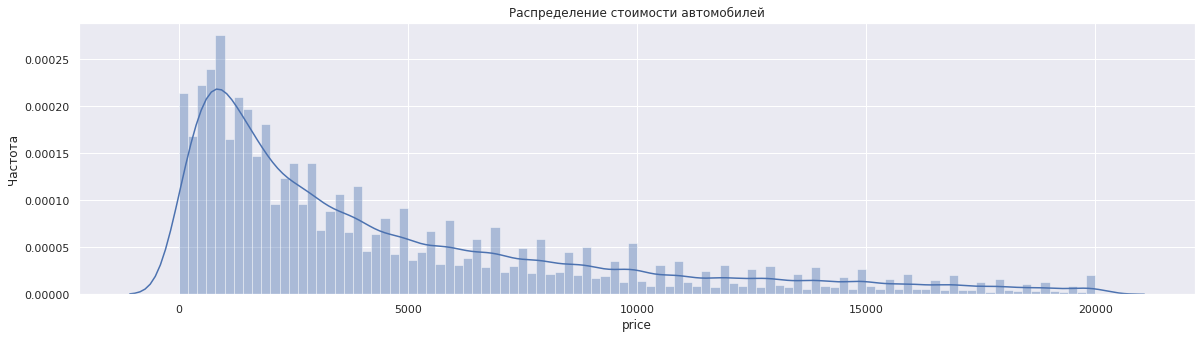

In [32]:
sns.set()
fig, ax = plt.subplots(figsize=(20, 5))
sns.distplot(df['price'], bins=100)
ax.set_title('Распределение стоимости автомобилей')
plt.ylabel('Частота')

In [33]:
def minimax (column, min1, max1):
    min_count = 0
    max_count = 0 
    var = df[column].reset_index(drop=True)
    for i in range(len(var)):
        if  var[i] <= min1:
            min_count += 1
        elif var[i] >= max1:
            max_count += 1
    print ('\n'.join((f'Количество объявлений ниже или равно параметру {min1}: {min_count} шт.',
                      f'Количество объявлений выше или равно параметру {max1}: {max_count} шт.',
                      f'Общее количество таких объявлений: {min_count+max_count} шт.',
                      f'% таких объявлений от всей выборки: {round((min_count+max_count)/len(var)*100, 2)} %')))

In [34]:
# меняем 0 на Nan
def zero_nan (column):
    df.loc[(df[column] == 0), (column)] = np.NaN

In [35]:
MIN_PRICE = 200
MAX_PRICE = 15000
zero_nan ('price')
analog('price', 'brand', 'model')

In [36]:
print ('*Выбросы* целевого признака:')
minimax ('price', MIN_PRICE, MAX_PRICE)

*Выбросы* целевого признака:
Количество объявлений ниже или равно параметру 200: 7555 шт.
Количество объявлений выше или равно параметру 15000: 15059 шт.
Общее количество таких объявлений: 22614 шт.
% таких объявлений от всей выборки: 6.76 %


In [37]:
#В целевом признаке много выбросов. Удалим строки соответствующие критерию - менее 200 и более 15000 евро.
df = df[(df['price']>MIN_PRICE) & (df['price']<MAX_PRICE)]

### Признак Power

<AxesSubplot:xlabel='power'>

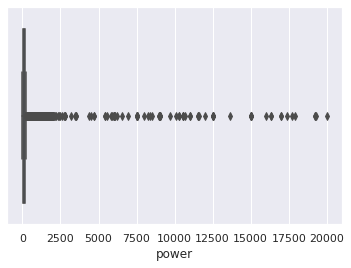

In [38]:
sns.boxplot(df['power'])

<AxesSubplot:xlabel='power'>

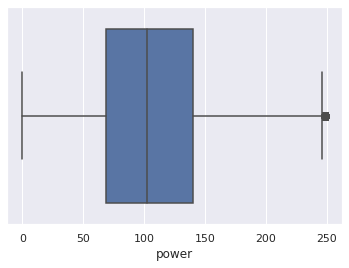

In [39]:
power_min = df[df['power']<=250]
sns.boxplot(power_min['power'])

In [40]:
MIN_POWER = 5
MAX_POWER = 250
#заменим "нулевые" мощности, на мощности похожих моделей
zero_nan ('power')
df.loc[(df['power'] > MAX_POWER), ('power')] = np.NaN
analog('power', 'brand', 'model')
df.loc[(df['power'] == 'other'), ('power')] = 0
df['power'] = pd.to_numeric(df['power'])

In [41]:
print ('*Выбросы* по признаку *Power*:')
minimax ('power', MIN_POWER, MAX_POWER)

*Выбросы* по признаку *Power*:
Количество объявлений ниже или равно параметру 5: 72 шт.
Количество объявлений выше или равно параметру 250: 711 шт.
Общее количество таких объявлений: 783 шт.
% таких объявлений от всей выборки: 0.25 %


In [42]:
#В признаке очень много выбросов, причем явно являющимися "ошибочными" данными.
# Удалим строки соответствующие критерию - равно 0 и более 250.
df = df[(df['power']>MIN_POWER) & (df['power']<MAX_POWER)]

### Признак Registrationmonth

In [43]:
print (df['registrationmonth'].value_counts())

3     30844
6     28070
0     27672
5     26045
4     26015
7     24268
10    23510
12    21884
11    21711
9     21406
1     20410
8     20336
2     19092
Name: registrationmonth, dtype: int64


**- порядка 15% данных в солбце registrationmonth содержад 0**  
**- однако данный столбец не является важным для построения модели, поэтому для облегчения расчетов - удалим его**

In [44]:
df=df.drop(['registrationmonth'], axis=1)

### Признак Registrationyear

In [45]:
df['registrationyear'].unique()

array([1993, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2011,
       1985, 1982, 1976, 1973, 2015, 1969, 1971, 1987, 1983, 1988, 1986,
       1965, 1970, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977, 1961,
       1960, 1966, 1963, 1954, 1967, 9999, 1500, 2200, 1975, 1964, 2066,
       1949, 1962, 2019, 1937, 1951, 1959, 9000, 2900, 1953, 1000, 5911,
       1400, 5000, 4000, 1952, 1200, 8500, 1958, 1950, 3700, 1942, 1935,
       1956, 3000, 1936, 1957, 1923, 2290, 1930, 1001, 1234, 7000, 1929,
       1938, 1934, 1943, 1928, 1941, 1919, 5555, 1800, 1932, 6000, 1931,
       4500, 1602, 1111, 7800, 7100, 1300, 8200, 2500, 7500, 1600])

Text(0, 0.5, 'Частота')

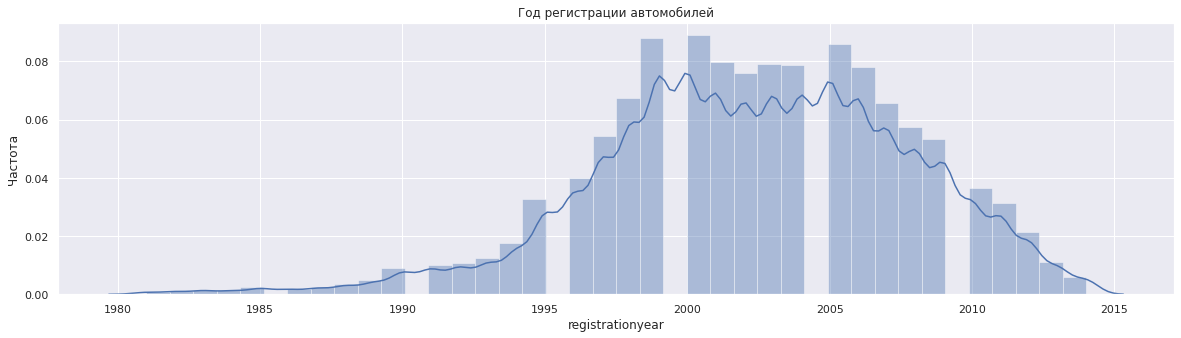

In [46]:
registration = df[(df['registrationyear']<2015) & (df['registrationyear']>1980)]
sns.set()
fig, ax = plt.subplots(figsize=(20, 5))
sns.distplot(registration['registrationyear'], bins=40)
ax.set_title('Год регистрации автомобилей')
plt.ylabel('Частота')

In [47]:
print (df.shape)

# уберем из данных все "выбросы" - автоиобили младже 1990 годы и старше 2015 
# (дата последних изменений в базе - начало апреля 2016)
# порядка 9,6% выборки

MIN_YEAR = 1990
MAX_YEAR = 2015
df = df[(df['registrationyear']>=MIN_YEAR) & (df['registrationyear']<=MAX_YEAR)]

print (df.shape)

(311263, 14)
(284236, 14)


### Прочие признаки

In [48]:
#графы datecrawled, datecreated, lastseen неважны для наше1 модели, поэтому удаляем их
#все значения в столбце numberofpictures равны 0 - удаляем их
#в графе postalcode нет выбивающихся значений, какой-то приоритетный район определить из имеющихся данных не вохможно
#так же удалим ее
df=df.drop(['datecrawled', 'datecreated', 'lastseen', 'postalcode','numberofpictures'], axis=1)

In [49]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284236 entries, 0 to 354364
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             284236 non-null  float64
 1   vehicletype       284236 non-null  object 
 2   registrationyear  284236 non-null  int64  
 3   gearbox           284236 non-null  object 
 4   power             284236 non-null  float64
 5   model             284236 non-null  object 
 6   kilometer         284236 non-null  int64  
 7   brand             284236 non-null  object 
 8   notrepaired       284236 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.7+ MB


,price,registrationyear,power,kilometer,notrepaired
count,284236.000000,284236.000000,284236.000000,284236.000000,284236.000000
mean,4113.818271,2002.634554,114.838328,130568.260178,0.099738
std,3637.738273,5.045843,44.025551,35015.549050,0.299650
min,202.000000,1990.000000,6.000000,5000.000000,0.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,0.000000
50%,2800.000000,2003.000000,109.000000,150000.000000,0.000000
75%,6000.000000,2006.000000,143.000000,150000.000000,0.000000
max,14999.000000,2015.000000,249.000000,150000.000000,1.000000


In [50]:
def price_plot (column, title):
    price = df[[column, 'price']].groupby(column, as_index=False).mean().astype('int')
    plt.figure(figsize=(20,5))
    plt.grid(axis = 'both')
    sns.lineplot(x=column, y='price', data=price)
    plt.xlabel(column, size=12)
    plt.ylabel('Цена, евро')
    plt.title(title)
    plt.show()

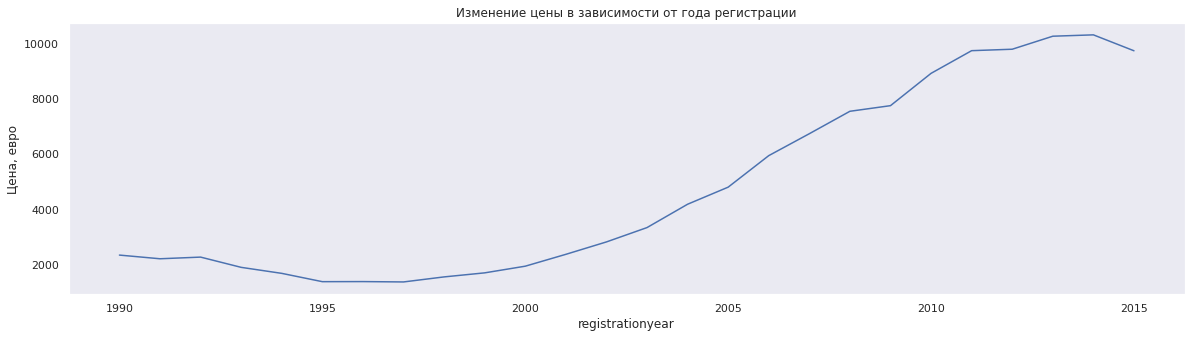

In [51]:
price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

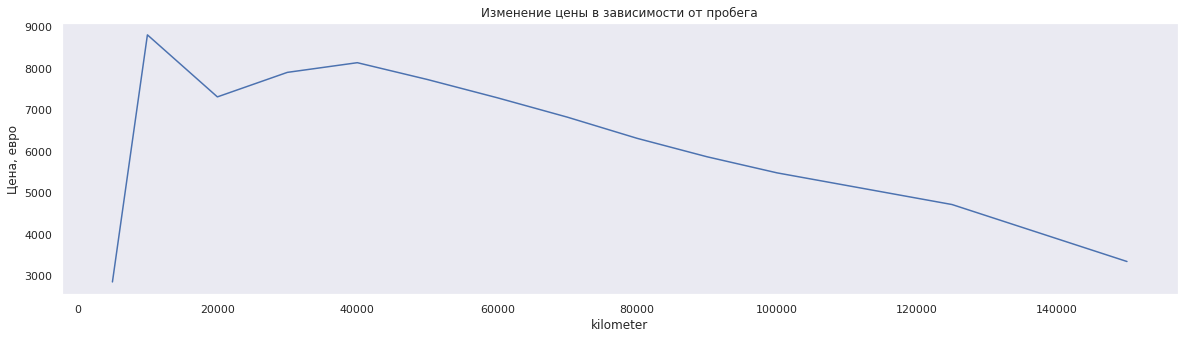

In [52]:
price_plot('kilometer', 'Изменение цены в зависимости от пробега')

**ВЫВОД:**  
**- в данных имелось множество пропусков и некорректных данных**  
**- так же было много выбросов, в основном связанных с некорректными данными**  
**- пропуски и поддающиеся анализу данные были заменены данными из похожих строчек**  
**- данные где значения не возможно было подставить без сильного искажения общей картины, были удалены**  
**- так же были удалены данные напрямую не влияющие на модель, а так же данные, которые могли привести к сильному переобучению модели**    
**- имеется некоторая аномалия в цене при пробеге менее 10000 км, возможно это нормальное поведение в данных. Так как количество значений мало (чуть более 1%), оставили их без изменений
**- после преобразования и очистки данных, "потери" в данных составили 19,79%**


## Обучение моделей

In [53]:
# кодирование категориальных данных
category_columns = list(df.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in category_columns:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,brand,notrepaired
0,480.0,4,1993,1,75.0,116,150000,37,0
2,9800.0,6,2004,0,163.0,117,125000,14,0
3,1500.0,5,2001,1,75.0,116,150000,37,0
4,3600.0,5,2008,1,69.0,101,90000,31,0
5,650.0,4,1995,1,102.0,11,150000,2,1


In [54]:
target=df['price']
features=df.drop(['price'],axis=1)

In [55]:
#стандартизируем признаки
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [56]:
train_features, test_features, train_target, test_target = train_test_split(features, target,
                                                                         test_size=0.2, random_state=12345)
train_valid_features, test_valid_features, train_valid_target, test_valid_target = train_test_split(test_features,
                                                                         test_target, test_size=0.5, random_state=12345)

In [57]:
# функция для расчета времени и RMSE
def time_rmse (model, train_features, train_target, test_features, test_target):
    start_train= time.time()    
    model.fit(train_features, train_target)
    training_time = time.time() - start_train
    start_predict = time.time()  
    predict = model.predict(test_features)
    predict_time = time.time() - start_predict
    rmse = mse(test_target, predict)**0.5
    print ('\n'.join((f'Время на обучение: {training_time} секунд.',
                            f'Время на предсказания: {predict_time} секунд.',
                            f'RMSE: {rmse}')))
    return training_time, predict_time, rmse

In [58]:
value = []
#kros_val = KFold(n_splits=3, shuffle=True, random_state=12345)
#kros_val = 3

In [59]:
# С кросс-валтдацией cv=kros_val
def grid (model, params):
    grid_search = GridSearchCV(model,
                          param_grid=params,
                          cv=ShuffleSplit(n_splits=1, random_state=12345),
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
    grid_search.fit(train_features, train_target)
    print ('Лучшие параметры модели с кросс-валидацией:', grid_search.best_params_)
    return value.append(time_rmse(grid_search.best_estimator_,
                                  train_features,
                                  train_target,
                                  test_valid_features,
                                  test_valid_target))
#без кросс-валидации  cv = ShuffleSplit(n_splits=1, random_state=12345),


### Ridge

In [60]:
#ridge = Ridge()
#params_ridge = {
#    'alpha': np.logspace(-5, 5, 20),
#    'random_state' : [12345]
#}

In [61]:
ridge = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                  ('scaler', StandardScaler(with_mean=False)),
                  ('model', Ridge(random_state=12345))])

params_ridge = [{'model__alpha': np.logspace(-5, 5, 20)}]

In [62]:
%%time
print ('Без гиперпараметров:')
value.append(time_rmse(ridge, train_features, train_target, test_valid_features, test_valid_target))

Без гиперпараметров:
Время на обучение: 0.4810750484466553 секунд.
Время на предсказания: 0.023039817810058594 секунд.
RMSE: 1686.3889572985363
CPU times: user 474 ms, sys: 23.7 ms, total: 498 ms
Wall time: 505 ms


In [63]:
%%time
print ('C гиперпараметрами:')
grid (ridge, params_ridge)

C гиперпараметрами:
Лучшие параметры модели с кросс-валидацией: {'model__alpha': 69.51927961775606}
Время на обучение: 0.49286532402038574 секунд.
Время на предсказания: 0.025146484375 секунд.
RMSE: 1686.3993031571947
CPU times: user 9.57 s, sys: 466 ms, total: 10 s
Wall time: 10 s


### LGBMRegressor

In [67]:
lgb = LGBMRegressor (random_state = 12345)
params_lgb = {
    'boosting_type' : ['gbdt'],
    'n_estimators': [50, 100],
    'verbose' : [0], 
    'force_col_wise': [True], 
    'num_leaves' : [10, 25, 50]
}

#params = {'boosting_type' : ['gbdt'], 'random_state' : [12345]}

In [68]:
%%time
print ('Без гиперпараметров:')
value.append(time_rmse(lgb, train_features, train_target, test_valid_features, test_valid_target))

Без гиперпараметров:
Время на обучение: 5.924284219741821 секунд.
Время на предсказания: 0.20331954956054688 секунд.
RMSE: 1480.147773973536
CPU times: user 6.04 s, sys: 57.8 ms, total: 6.1 s
Wall time: 6.13 s


In [69]:
%%time
print ('C гиперпараметрами:')
grid (lgb, params_lgb)

C гиперпараметрами:
Лучшие параметры модели с кросс-валидацией: {'boosting_type': 'gbdt', 'force_col_wise': True, 'n_estimators': 100, 'num_leaves': 50, 'verbose': 0}
Время на обучение: 5.703192472457886 секунд.
Время на предсказания: 0.2958512306213379 секунд.
RMSE: 1447.6023100110397
CPU times: user 37.1 s, sys: 147 ms, total: 37.2 s
Wall time: 38.2 s


### CatBoostingRegressor

In [70]:
cat = CatBoostRegressor (random_state = 12345)
params_cat = {
    'n_estimators': [50, 100],
    'verbose' : [0], 
    'depth': [2, 5, 10],   
}

In [71]:
%%time
print ('Без гиперпараметров:')
value.append(time_rmse(cat, train_features, train_target, test_valid_features, test_valid_target))

Без гиперпараметров:
Learning rate set to 0.096505
0:	learn: 3406.8600692	total: 81.8ms	remaining: 1m 21s
1:	learn: 3206.8586163	total: 111ms	remaining: 55.5s
2:	learn: 3029.6350543	total: 140ms	remaining: 46.7s
3:	learn: 2874.3110022	total: 169ms	remaining: 42s
4:	learn: 2736.5059685	total: 197ms	remaining: 39.2s
5:	learn: 2612.8479840	total: 226ms	remaining: 37.4s
6:	learn: 2507.9458452	total: 254ms	remaining: 36s
7:	learn: 2415.6059503	total: 284ms	remaining: 35.3s
8:	learn: 2336.5124065	total: 313ms	remaining: 34.4s
9:	learn: 2266.2881745	total: 343ms	remaining: 34s
10:	learn: 2202.4870464	total: 371ms	remaining: 33.4s
11:	learn: 2146.6371561	total: 399ms	remaining: 32.9s
12:	learn: 2097.2663325	total: 427ms	remaining: 32.4s
13:	learn: 2054.9418416	total: 455ms	remaining: 32s
14:	learn: 2018.5500424	total: 482ms	remaining: 31.6s
15:	learn: 1987.0779069	total: 509ms	remaining: 31.3s
16:	learn: 1956.2358883	total: 538ms	remaining: 31.1s
17:	learn: 1931.0852548	total: 564ms	remaining:

In [72]:
%%time
print ('C гиперпараметрами:')
grid (cat, params_cat)

C гиперпараметрами:
Лучшие параметры модели с кросс-валидацией: {'depth': 10, 'n_estimators': 100, 'verbose': 0}
Время на обучение: 5.944325923919678 секунд.
Время на предсказания: 0.05589580535888672 секунд.
RMSE: 1400.024238900562
CPU times: user 26.7 s, sys: 126 ms, total: 26.8 s
Wall time: 32.8 s


### XGBRegressor

In [73]:
xgb = XGBRegressor (random_state = 12345)
params_xgb = {
    'max_depth': [2, 5, 10], 
    'eta': [0.5], 
    'min_child_weight':[4],
    'sampling_method':['gradient_based'], 
    'verbosity':[0],  
}


In [74]:
%%time
print ('Без гиперпараметров:')
value.append(time_rmse(xgb, train_features, train_target, test_valid_features, test_valid_target))

Без гиперпараметров:
Время на обучение: 39.652671337127686 секунд.
Время на предсказания: 0.09081435203552246 секунд.
RMSE: 1409.8742265982162
CPU times: user 39.2 s, sys: 67.3 ms, total: 39.2 s
Wall time: 39.7 s


In [75]:
%%time
print ('C гиперпараметрами:')
grid (xgb, params_xgb)

C гиперпараметрами:
Лучшие параметры модели с кросс-валидацией: {'eta': 0.5, 'max_depth': 10, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'verbosity': 0}
Время на обучение: 77.11841607093811 секунд.
Время на предсказания: 0.12207674980163574 секунд.
RMSE: 1357.8506765406164
CPU times: user 4min 3s, sys: 476 ms, total: 4min 4s
Wall time: 4min 8s


## Анализ моделей

In [76]:
time.sleep(10)
pd.DataFrame(data=value,
             index=['Ridge Без гиперпараметров', 'Ridge C гиперпараметрами:', 
                    'LGBMRegressor Без гиперпараметров', 'LGBMRegressor C гиперпараметрами:',
                    'CatBoost Без гиперпараметров', 'CatBoost C гиперпараметрами:',
                    'XGBRegressor Без гиперпараметров', 'XGBRegressor C гиперпараметрами:'], 
             columns=['trainig_time', 'predic_time', 'RMSE'])

,trainig_time,predic_time,RMSE
Ridge Без гиперпараметров,0.481075,0.023040,1686.388957
Ridge C гиперпараметрами:,0.492865,0.025146,1686.399303
LGBMRegressor Без гиперпараметров,5.924284,0.203320,1480.147774
LGBMRegressor C гиперпараметрами:,5.703192,0.295851,1447.602310
CatBoost Без гиперпараметров,29.794214,0.074015,1406.968649
CatBoost C гиперпараметрами:,5.944326,0.055896,1400.024239
XGBRegressor Без гиперпараметров,39.652671,0.090814,1409.874227
XGBRegressor C гиперпараметрами:,77.118416,0.122077,1357.850677


**Протестируем 2 наши лучшие модели на тестовой выборке с применением лучших параметров**

In [77]:
%%time
model = LGBMRegressor(boosting_type='gbdt',
                      force_col_wise=True,
                      n_estimators=100,
                      num_leaves=50,
                      random_state=12345,
                      verbose=0)
model.fit(train_features, train_target)
rmse = mse(test_target, model.predict(test_features))**0.5
print ('RMSE на тестовой выборке', rmse)

RMSE на тестовой выборке 1435.5154057743302
CPU times: user 5.8 s, sys: 28 ms, total: 5.83 s
Wall time: 5.88 s


In [78]:
%%time
model = CatBoostRegressor(depth=10,
                          n_estimators=100,
                          random_state=12345,
                          verbose=0)
model.fit(train_features, train_target)
rmse = mse(test_target, model.predict(test_features))**0.5
print ('RMSE на тестовой выборке', rmse)

RMSE на тестовой выборке 1381.1860384134898
CPU times: user 5.77 s, sys: 8.34 ms, total: 5.78 s
Wall time: 6.83 s


**- хуже всего по качеству оказались модели Ridge и Lasso**  
**- самая медленная модель - XGBRegressor, однако у нее один из лучших результатов**  
**- LGBMRegressor и CatBoost при тренировки модели показали примерно одинаковое качество и время обучения**  
**- однако на тестовой выборке однозначно преимущество у CatBoost как по качеству, так и по затратам времени.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей